In [2]:
!pip install malaya_speech
!pip install spectralcluster
!pip install pydub
import pandas as pd
import os
import json
from google.colab import files
import librosa as librosa
import librosa.display
import IPython.display as ipd
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt
from spectralcluster import SpectralClusterer
from pydub import AudioSegment
from pydub.silence import split_on_silence
import math

!pip install catboost
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier #KNN
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score #score evaluation

from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
caller_audio = files.upload()

Saving calleraudio.zip to calleraudio.zip


In [4]:
agent_audio = files.upload()

Saving agentaudio.zip to agentaudio.zip


In [5]:
transcripts = files.upload()

Saving transcripts.zip to transcripts.zip


In [26]:
!unzip -q calleraudio.zip

In [27]:
!unzip -q agentaudio.zip

In [28]:
!unzip -q transcripts.zip

replace transcripts/00d676d7058c49bb.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [9]:
# Average word duration per block
def calc_word_dur(lst):
  sum = 0
  for i in range(len(lst)):
    sum += lst[i]
  return sum/len(lst)

# Averages by speaker -> returns average neutral, negative, positive emotions and average speech duration and average of averages word duration of the entire record.
def calc_data(data, speaker):
  counter = 0
  neu = 0
  neg = 0
  pos = 0
  total_dur = 0
  word_dur = 0
  sentence_len = 0
  for i in range(len(data)):
    if(data[i]['speaker_role'] == speaker):
      counter += 1
      neu += float(data[i]['emotion']['neutral'])
      neg += float(data[i]['emotion']['negative'])
      pos += float(data[i]['emotion']['positive'])
      total_dur += int(data[i]['duration_ms'])
      word_dur += int(calc_word_dur(data[i]['word_durations_ms']))
      sentence_len += int(len(data[i]['transcript'].split()))

  neu /= counter
  neg /= counter
  pos /= counter
  total_dur /= counter
  word_dur /= counter
  sentence_len /= counter


  return [neu, neg, pos, total_dur, word_dur, sentence_len]

In [10]:
def makeTenSecondsAudio(filename):
  #Load audio
  # y, sr = malaya_speech.load(filename)
  y, sr = librosa.load(filename)

  #Cuts silence from the beggining and the end of the call
  y_trim = librosa.effects.trim(y, top_db=20)[0]

  #Cuts dead audio moments
  y_int = malaya_speech.astype.float_to_int(y_trim)
  audio = AudioSegment(
      y_int.tobytes(),
      frame_rate = sr,
      sample_width = y_int.dtype.itemsize,
      channels = 1
  )
  audio_chunks = split_on_silence(
      audio,
      min_silence_len = 200,
      silence_thresh = -30,
      keep_silence = 100,
  )
  
  #Sums all active audio parts and creates a united audio file
  final_y = sum(audio_chunks)
  final_y = np.array(final_y.get_array_of_samples())
  final_y = malaya_speech.astype.int_to_float(final_y)
  
  #If longer then 10 seconds, shortens to 10 ; otherwise remainds the same
  final_y = final_y[:sr*10]

  return final_y, sr

In [11]:
def amplitude_envelope(signal, frame_size, hop_length):
  amp_env = []

  # calculate AE for each frame
  for i in range(0, len(signal), hop_length):
    current_amp_env = max(signal[i:i+frame_size])
    amp_env.append(current_amp_env)
  
  ae_array = np.array(amp_env)

  dictionary = {}
  dictionary['average'] = np.average(ae_array)
  dictionary['max'] = np.max(ae_array)
  dictionary['min'] = np.min(ae_array)
  dictionary['std'] = np.std(ae_array)
  dictionary['median'] = np.median(ae_array)
  
  return dictionary

In [12]:
def rms(signal, frame_size, hop_length):
  rms = []

  for i in range(0, len(signal), hop_length):
    current_frame = np.sqrt(np.sum(signal[i:i+frame_size]**2)/frame_size)
    rms.append(current_frame)
  
  rms = np.array(rms)

  dictionary = {}
  dictionary['average'] = np.average(rms)
  dictionary['max'] = np.max(rms)
  dictionary['min'] = np.min(rms)
  dictionary['std'] = np.std(rms)
  dictionary['median'] = np.median(rms)
  
  return dictionary

In [13]:
def zcr(signal, frame_size, hop_length):
  zcr_signal = librosa.feature.zero_crossing_rate(signal, frame_length=frame_size, hop_length=hop_length)[0]

  dictionary = {}
  dictionary['average'] = np.average(zcr_signal)
  dictionary['max'] = np.max(zcr_signal)
  dictionary['min'] = np.min(zcr_signal)
  dictionary['std'] = np.std(zcr_signal)
  dictionary['median'] = np.median(zcr_signal)

  return dictionary

In [14]:
def log_mel_spectrogram_data(signal,sr , n_fft, hop_length):
  #Create MelSpectrogram
  mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, win_length=n_fft) ##, n_mels=mel_bins)

  #Create LogMelSpectrogram out of the MelSpectrogram
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

  dictionary = {}
  dictionary['average'] = np.average(log_mel_spectrogram)
  dictionary['max'] = np.max(log_mel_spectrogram)
  dictionary['min'] = np.min(log_mel_spectrogram)
  dictionary['std'] = np.std(log_mel_spectrogram)
  dictionary['median'] = np.median(log_mel_spectrogram)

  return dictionary

In [15]:
def mfcc(signal, n_mfcc, sr):
  mfcc = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr)

  dictionary = {}
  dictionary['average'] = np.average(mfcc)
  dictionary['max'] = np.max(mfcc)
  dictionary['min'] = np.min(mfcc)
  dictionary['std'] = np.std(mfcc)
  dictionary['median'] = np.median(mfcc)

  return dictionary


In [16]:
def createDataExample(signal, sr, frame_size, hop_length, n_fft, n_mfcc):
  amp_env = []
  rms = []

  # calculate AE for each frame
  for i in range(0, len(signal), hop_length):
    current_amp_env = max(signal[i:i+frame_size])
    amp_env.append(current_amp_env)
  
  ae_array = np.array(amp_env)

  # calculate RMS for each frame
  for i in range(0, len(signal), hop_length):
    current_frame = np.sqrt(np.sum(signal[i:i+frame_size]**2)/frame_size)
    rms.append(current_frame)
  
  rms = np.array(rms)

  # ZCR
  zcr_signal = librosa.feature.zero_crossing_rate(signal, frame_length=frame_size, hop_length=hop_length)[0]


  #Create MelSpectrogram
  mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, win_length=n_fft) ##, n_mels=mel_bins)

  #Create LogMelSpectrogram out of the MelSpectrogram
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

  # MFCC
  mfcc = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr)

  return [ae_array, rms, zcr_signal, mel_spectrogram, log_mel_spectrogram, mfcc]

In [17]:
def createAudioDataRow(dict1, dict2, dict3, dict4, dict5):
  lst = np.append(list(dict1.values()), list(dict2.values()))
  lst = np.append(lst, list(dict3.values()))
  lst = np.append(lst, list(dict4.values()))
  lst = np.append(lst, list(dict5.values()))

  return lst
  

In [18]:
# Audio feature extraction and return data
def audio_data_calc(path, name):
  filename = path + name
  signal, sr = makeTenSecondsAudio(filename)

  # properties
  FRAME_SIZE = 256
  N_FFT = 256
  HOP_LENGTH = 128
  N_MFCC=13

  # Time-Domain Features
  amp_env = amplitude_envelope(signal, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
  rms_signal = rms(signal, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
  zcr_signal = zcr(signal, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)

  # Time-Frequency-Domain Features
  log_mel = log_mel_spectrogram_data(signal, sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
  mfcc_ = mfcc(signal, n_mfcc=N_MFCC, sr=sr)

  features = createAudioDataRow(amp_env, rms_signal, zcr_signal, log_mel, mfcc_)
  

  return features

In [19]:
def extraction(key):
  #Load json file (transcript)
  filename = str(key)
  with open(os.path.join('transcripts', filename), 'r') as f:
    data = json.load(f)

  # Extract transcript data
  agent_data = calc_data(data,'agent')
  caller_data = calc_data(data,'caller')
  
  #Change filename to .wav from .json
  filename = filename.split('.')
  filename = filename[0]
  filename = filename + '.wav'

  # Extract audio features data
  agent_audio_data = audio_data_calc('./agentaudio/', filename)
  caller_audio_data = audio_data_calc('./calleraudio/', filename)

  # Build a row of a single prediction of each type for each < json : (agent wav, caller wav) >
  agent_row = np.append(agent_data, agent_audio_data)
  caller_row = np.append(caller_data, caller_audio_data)

  # Y label
  # Assuming that the agent is the higher status in this dataset
  agent_row = np.append(agent_row, [1])
  caller_row = np.append(caller_row, [0])

  # Return the row into the dataframe
  return agent_row, caller_row

In [38]:
def createDataset():
  # Properties
  completed_files = []
  id_counter = 0

  # Create Labels Row Here
  labels = ['ID','Filename', 'Neutral', 'Negative', 'Positive', 'Avg_Sentence_Duration', 'Avg_Word_Duration','Avg_Sentence_Length',
            'Amp_Env_Avg', 'Amp_Env_Max', 'Amp_Env_Min','Amp_Env_STD', 'Amp_Env_Median',
            'RMS_Avg', 'RMS_Max', 'RMS_Min','RMS_STD', 'RMS_Median',
            'ZCR_Avg', 'ZCR_Max', 'ZCR_Min','ZCR_STD', 'ZCR_Median',
            'Mel_Spec_Avg', 'Mel_Spec_Max', 'Mel_Spec_Min','Mel_Spec_STD', 'Mel_Spec_Median',
            'MFCC_Avg', 'MFCC_Max', 'MFCC_Min','MFCC_STD', 'MFCC_Median','Label']

  # Create empty data framehere
  mydataframe = pd.DataFrame(columns = labels)

  # Extract all data
  directory = 'transcripts'
  tempCounter = 0
  for filename in os.listdir(directory):
    if not filename in completed_files:
      print(f"{tempCounter} : {filename}")
      completed_files.append(filename)
      agent_features, caller_features = extraction(filename)

      agent_row = np.append([id_counter, filename.split(".")[0]], agent_features)
      id_counter += 1
      caller_row = np.append([id_counter, filename.split(".")[0]], caller_features)
      id_counter += 1
      # add rows to the dataframe
      mydataframe.loc[len(mydataframe.index)] = agent_row
      mydataframe.loc[len(mydataframe.index)] = caller_row
      tempCounter += 1
  return mydataframe

In [39]:
df = createDataset()

df

0 : 0cae8d624dc04b47.json


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


1 : 0f87dc392db84250.json
2 : 0e2ad0dd8a6f4f83.json
3 : 0ec73a168f174a86.json
4 : 0b5d3de182a04159.json
5 : 00f7dce6fc3849a2.json
6 : 0d7efd9a397e4e02.json
7 : 0a6f57765f4641a2.json
8 : 1b8d578a554c426a.json
9 : 0b590e61350b4b53.json
10 : 0b41e7d162844d45.json
11 : 0ec40e7af4444ad5.json
12 : 01f7ec3700424bc0.json
13 : 0bf0d8398c574373.json
14 : 1d31f40348ab4e5a.json
15 : 0c78f55cf0e3449f.json
16 : 1c9c4822cbcd4676.json
17 : 0bf2b746d42b4f84.json
18 : 0ade4b6adcf941f0.json
19 : 00d676d7058c49bb.json
20 : 0f65cbb7a9a34628.json
21 : 1ad1284bc1cf4e33.json
22 : 0f4747d1a97f4388.json
23 : 0e8b236db74847ae.json
24 : 0b153339c9184252.json
25 : 1ab5ddcc434d4997.json
26 : 1c4c69c3dc3d470d.json
27 : 0bb871fd99d6437f.json
28 : 1a1691098ae1400c.json
29 : 0c7b8cd8a7374ffc.json
30 : 0f8e8b5f72bb4594.json
31 : 0f590c57de074605.json
32 : 1b5cab5af4764845.json
33 : 0ece8b36d4c148b0.json
34 : 0df279dab5a44e6c.json
35 : 1c4e1b0407594bb9.json
36 : 0bbbedb40f224e9a.json
37 : 0df17344420a41d5.json
38 : 0a70a

,ID,Filename,Neutral,Negative,Positive,Avg_Sentence_Duration,Avg_Word_Duration,Avg_Sentence_Length,Amp_Env_Avg,Amp_Env_Max,...,Mel_Spec_Max,Mel_Spec_Min,Mel_Spec_STD,Mel_Spec_Median,MFCC_Avg,MFCC_Max,MFCC_Min,MFCC_STD,MFCC_Median,Label
0,0,0cae8d624dc04b47,0.3988823115825653,0.08047228194773197,0.5206453949213028,2454.0,226.6,11.0,0.20638114213943481,0.9891353845596313,...,0.0,-80.0,19.125356674194336,-80.0,-23.200510025024414,234.6202850341797,-527.8937377929688,99.40010070800781,-10.456596374511719,1.0
1,1,0cae8d624dc04b47,0.3953635275363922,0.11517593041062354,0.4894605278968811,1392.0,236.8,6.0,0.1887020319700241,1.0,...,0.0,-80.0,18.492034912109375,-78.79158020019531,-18.055545806884766,232.97300720214844,-472.8939514160156,90.85176849365234,-9.589393615722656,0.0
2,2,0f87dc392db84250,0.5032209626265934,0.10226675016539437,0.3945122893367495,2845.714285714286,292.2857142857143,8.428571428571429,0.22764649987220764,0.8930631279945374,...,9.5367431640625e-07,-80.0,20.875497817993164,-75.29769134521484,-13.147513389587402,272.6185302734375,-511.17327880859375,99.73933410644531,-7.653861045837402,1.0
3,3,0f87dc392db84250,0.45714999238650006,0.16964580097960102,0.37320421636104584,1460.0,476.3333333333333,3.7777777777777777,0.19641470909118652,1.0,...,0.0,-80.0,19.175586700439453,-80.0,-22.817087173461914,251.97012329101562,-528.4066162109375,101.46794891357422,-10.016624450683594,0.0
4,4,0e2ad0dd8a6f4f83,0.4936603506406148,0.06813414301723242,0.4382055103778839,1990.0,176.66666666666666,9.0,0.17791453003883362,1.0,...,-9.5367431640625e-07,-80.0,19.925464630126953,-72.15589904785156,-22.932247161865234,235.37547302246094,-468.8534851074219,95.64179992675781,-10.772595405578613,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,135,0f17604f0b72402f,0.42944709658622743,0.1552870787680149,0.41526583433151243,1548.0,278.2,6.2,0.21909627318382263,1.0,...,-9.5367431640625e-07,-80.0,19.55413246154785,-80.0,-22.803117752075195,242.58526611328125,-528.9222412109375,98.24608612060547,-11.552371978759766,0.0
136,136,1d1ad6e932d44146,0.5853574673334757,0.05793366695029868,0.3567088759607739,1676.6666666666667,188.66666666666666,6.888888888888889,0.10815607011318207,0.8571733832359314,...,0.0,-80.0,18.43621253967285,-78.0315170288086,-20.600746154785156,246.79183959960938,-515.831298828125,103.86677551269531,-8.305047988891602,1.0
137,137,1d1ad6e932d44146,0.47855958342552185,0.22434267603481808,0.29709772517283756,1890.0,246.66666666666666,6.833333333333333,0.2700819969177246,1.0,...,0.0,-80.0,21.505693435668945,-69.07080841064453,-9.631065368652344,289.83428955078125,-534.552001953125,102.3518295288086,-4.4944257736206055,0.0
138,138,1d4a688a2f514fd4,0.5208165968457857,0.12084032300238808,0.35834307968616486,1275.0,231.0,5.25,0.16879449784755707,0.9975585341453552,...,0.0,-80.0,20.82857322692871,-71.97516632080078,-23.609514236450195,244.74301147460938,-467.42535400390625,102.18352508544922,-10.699956893920898,1.0


In [56]:
y_df = df.iloc[:,-1].values
x_df = df.drop(['ID',"Filename", "Label"], axis=1, inplace=False)

In [57]:
#normelize the data using std
stdsc = StandardScaler()
x_std = stdsc.fit_transform(x_df)

In [58]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(x_std, y_df, test_size = 0.20)
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(x_test.shape))
print('X_test:  '  + str(y_train.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (112, 31)
Y_train: (28, 31)
X_test:  (112,)
Y_test:  (28,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


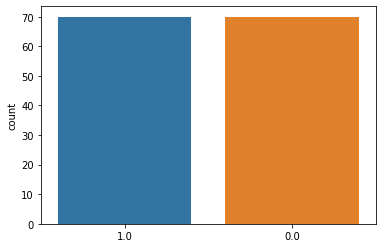

In [50]:
#check for imballance data
countplit = sns.countplot(y_df)

In [51]:
kfold = KFold(n_splits=5)
Means=[]
accuracy=[]
std=[]
classifiers=['Logistic Regression','KNN','CatBoost']
models=[LogisticRegression(),KNeighborsClassifier(n_neighbors=3),CatBoostClassifier(iterations=20,learning_rate=1,depth=2)]
for i in models:
    model = i
    cv_result = cross_val_score(model,x_train,y_train, cv = kfold,scoring = "accuracy")
    Means.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)

models_dataframe=pd.DataFrame({'CV Mean':Means,'Std':std},index=classifiers)  
models_dataframe 

0:	learn: 0.4497449	total: 970us	remaining: 18.4ms
1:	learn: 0.3364173	total: 2.48ms	remaining: 22.3ms
2:	learn: 0.2409197	total: 3.55ms	remaining: 20.1ms
3:	learn: 0.2078015	total: 4.57ms	remaining: 18.3ms
4:	learn: 0.1632652	total: 5.58ms	remaining: 16.7ms
5:	learn: 0.1549733	total: 6.58ms	remaining: 15.3ms
6:	learn: 0.1177848	total: 7.55ms	remaining: 14ms
7:	learn: 0.1008361	total: 8.52ms	remaining: 12.8ms
8:	learn: 0.0791208	total: 9.5ms	remaining: 11.6ms
9:	learn: 0.0653741	total: 10.5ms	remaining: 10.5ms
10:	learn: 0.0625938	total: 11.4ms	remaining: 9.36ms
11:	learn: 0.0502374	total: 12.4ms	remaining: 8.28ms
12:	learn: 0.0455601	total: 13.4ms	remaining: 7.23ms
13:	learn: 0.0435364	total: 14.4ms	remaining: 6.18ms
14:	learn: 0.0419023	total: 15.4ms	remaining: 5.13ms
15:	learn: 0.0318585	total: 16.4ms	remaining: 4.09ms
16:	learn: 0.0299219	total: 17.3ms	remaining: 3.06ms
17:	learn: 0.0261755	total: 18.3ms	remaining: 2.04ms
18:	learn: 0.0246287	total: 19.3ms	remaining: 1.01ms
19:	lea

,CV Mean,Std
Logistic Regression,0.785375,0.052609
KNN,0.618577,0.144114
CatBoost,0.724111,0.066956


In [52]:
#for catboost model
Cat_parameters = {'depth'         : [2,3,4,5,6,7,8,9, 10],
                 'learning_rate' : [0.001,0.01,0.1,1],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}

CBC = CatBoostClassifier()
Grid_CBC_reg = GridSearchCV(estimator=CBC, param_grid = Cat_parameters, cv = 2, n_jobs=-1)
Grid_CBC_reg.fit(x_train,y_train)


print(" \nResults from Grid Searc, CAT BOOST:" )
print("\n The best score across ALL searched params:\n",Grid_CBC_reg.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC_reg.best_params_)

0:	learn: 0.6872211	total: 1.42ms	remaining: 140ms
1:	learn: 0.6821457	total: 2.25ms	remaining: 110ms
2:	learn: 0.6760191	total: 3.09ms	remaining: 99.8ms
3:	learn: 0.6710572	total: 4.07ms	remaining: 97.7ms
4:	learn: 0.6665096	total: 5.19ms	remaining: 98.7ms
5:	learn: 0.6629724	total: 6.31ms	remaining: 98.8ms
6:	learn: 0.6545247	total: 7.34ms	remaining: 97.6ms
7:	learn: 0.6499649	total: 8.4ms	remaining: 96.7ms
8:	learn: 0.6447471	total: 9.45ms	remaining: 95.6ms
9:	learn: 0.6393689	total: 10.5ms	remaining: 94.6ms
10:	learn: 0.6368876	total: 11.9ms	remaining: 96ms
11:	learn: 0.6329622	total: 13ms	remaining: 95.3ms
12:	learn: 0.6283845	total: 14.1ms	remaining: 94.3ms
13:	learn: 0.6243328	total: 15.2ms	remaining: 93.5ms
14:	learn: 0.6185289	total: 16.4ms	remaining: 92.7ms
15:	learn: 0.6157968	total: 17.5ms	remaining: 91.8ms
16:	learn: 0.6124429	total: 18.5ms	remaining: 90.4ms
17:	learn: 0.6080452	total: 19.6ms	remaining: 89.1ms
18:	learn: 0.6052828	total: 20.6ms	remaining: 87.8ms
19:	learn:

In [53]:
#for catboost model

CBC = CatBoostClassifier(depth=3, iterations=10 , learning_rate=1).fit(x_train,y_train)

y_train_hat_reg_cat=CBC.predict(x_train)
train_accuracy=accuracy_score(y_train,y_train_hat_reg_cat)*100

y_test_hat_reg_cat=CBC.predict(x_test)
test_accuracy=accuracy_score(y_test,y_test_hat_reg_cat)*100

print("for regressin/catboost model:\ntrain accuracy:  ", train_accuracy, "  test accuracy:  ", test_accuracy)

0:	learn: 0.4305958	total: 1.23ms	remaining: 11.1ms
1:	learn: 0.3334235	total: 3.02ms	remaining: 12.1ms
2:	learn: 0.2680684	total: 4.43ms	remaining: 10.3ms
3:	learn: 0.2564846	total: 5.78ms	remaining: 8.67ms
4:	learn: 0.2155319	total: 7.15ms	remaining: 7.15ms
5:	learn: 0.1817633	total: 8.48ms	remaining: 5.65ms
6:	learn: 0.1668783	total: 9.8ms	remaining: 4.2ms
7:	learn: 0.1372295	total: 11.1ms	remaining: 2.78ms
8:	learn: 0.1047729	total: 12.5ms	remaining: 1.39ms
9:	learn: 0.0769629	total: 13.8ms	remaining: 0us
for regressin/catboost model:
train accuracy:   100.0   test accuracy:   71.42857142857143


In [64]:
# Classification training model - New Model
lr_model = LogisticRegression()

lr_params = {
            "penalty": ['l2','l1'],
            "C": np.logspace(-3,3,7),
            "solver": ['newton-cg', 'lbfgs', 'liblinear']
            }

lr_grid = GridSearchCV(lr_model, lr_params, scoring='accuracy', cv=10)

lr_grid.fit(x_df, y_df)

print(f"Logistic Regression Best Params:\n{lr_grid.best_params_}")

y_pred = lr_grid.predict(x_test)
print("Accuracy:",lr_grid.score(x_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression Best Params:
{'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.6071428571428571


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
